In [1]:
# System setup
import os
import sys
import time
os.chdir("C:/Users/BIYIHA/Documents/spark edx/Spark Course/bank data")
os.curdir

'.'

In [2]:
#start the SparkContext
import findspark
findspark.init()

from pyspark import SparkContext
from pyspark import SparkConf

In [3]:
# setup spark local resources
conf=SparkConf()
conf.set("spark.executor.memory", "2g")
conf.set("spark.cores.max", "4")

conf.setAppName("thebuzz bank")

sc = SparkContext("local", conf=conf)

#### Import Dataset

In [4]:
# read the input file into an RDD[String]
wholeFile = sc.textFile("bank-full.csv")

 #### Find Column Indexes

In [5]:
# Finds out the index of "name" in the array firstLine 
# returns -1 if it cannot find it
def findCol(firstLine, name):
	if name in firstLine:
		return firstLine.index(name)
	else:
		return -1

In [6]:
# The first line of the file defines the name of each column in the cvs file
# We store it as an array in the driver program
firstLine = wholeFile.collect()[0].replace('"','').split(';')

#### Clean Dataset

In [7]:
# filter out the first line from the initial RDD

from itertools import islice

entries = wholeFile.mapPartitionsWithIndex(
    lambda idx, it: islice(it, 1, None) if idx == 0 else it 
)

In [8]:
# split each line into an array of items (; since it seperates the colomns
bankData = entries.map(lambda x : x.split(';'))

In [9]:
# keep the RDD in memory
bankData.cache()

PythonRDD[2] at RDD at PythonRDD.scala:53

### Data Analysis can start

In [10]:
# Count the total number of observations included in the dataset
print("number of observations = ", bankData.count())

number of observations =  45211


In [11]:
# First find the index of the column corresponding to the "age"
column_index=findCol(firstLine, "job")
print("{} corresponds to column {}".format("job", column_index))

job corresponds to column 1


In [12]:
# Use 'map' to create a RDD with all jobs and 'distinct' to remove duplicates
jobs = bankData.map(lambda x: x[column_index]).distinct()

In [13]:
# Number of distinct jobs in the survey
jobs.count()

12

In [14]:
# Display the 5 first nationalities
print("A few examples of jobs:")
for elem in jobs.sortBy(lambda x: x).take(5):
	print(elem)

A few examples of jobs:
"admin."
"blue-collar"
"entrepreneur"
"housemaid"
"management"


#### How many samples are married

In [15]:
# First find the index of the column corresponding to the "marital"
col_idx_marital=findCol(firstLine, "marital")
print("{} corresponds to column {}".format("marital", col_idx_marital))

marital corresponds to column 2


In [16]:
# create RDD just for married individual
marital = bankData.map(lambda x: x[col_idx_marital]).filter(lambda x: x =='"married"')
marital.take(3)

['"married"', '"married"', '"married"']

In [17]:
print("number of married individuals = ", marital.count())

number of married individuals =  27214


#### Make histogram of marital status

In [18]:
# Count the marital status in RDD
maritalStatus = bankData.map(lambda x: x[col_idx_marital]).map(lambda status: (status, 1))
maritalStatus1 = maritalStatus.reduceByKey(lambda a,b: a+b)

In [19]:
maritalState = maritalStatus1.collect()
print(maritalState)

[('"married"', 27214), ('"single"', 12790), ('"divorced"', 5207)]


In [21]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

<BarContainer object of 3 artists>

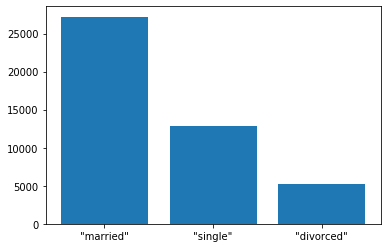

In [20]:
maritalState1= dict(maritalState)
plt.bar(maritalState1.keys(),maritalState1.values())
#maritalState1= np.array(maritalState)
#plt.bar(maritalState1[:,0], maritalState1[:,1].astype(int))

#### Create Histogram of age in dataset

age corresponds to column 0


<BarContainer object of 77 artists>

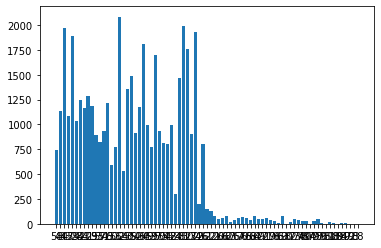

In [26]:
# First find the index of the column corresponding to the "ages"
col_idx_age=findCol(firstLine, "age")
print("{} corresponds to column {}".format("age", col_idx_age))

# Count the ages status in RDD
ages = bankData.map(lambda x: x[col_idx_age]).map(lambda a: (a, 1))
ages1 = ages.reduceByKey(lambda a,b: a+b)

# collect
ages2 = ages1.collect()
#print(ages2)

# plot histogram
ages3= dict(ages2)
plt.bar(ages3.keys(), ages3.values())

In [31]:
# print the 5 most frequent age 

reverse_age = ages1.map(lambda x: (x[1], x[0]))
sorted_Maxages = reverse_age.sortByKey(ascending=False)
#take the top 5 departure places
D = sorted_Maxages.take(5)
print('most sample ages \n'+'\n'.join(['%d:\t%s'%c for c in D]))

most sample ages 
2085:	32
1996:	31
1972:	33
1930:	34
1894:	35


In [40]:
# print the oldest and youngest age in dataset

oldest_age = bankData.map(lambda x: x[col_idx_age]).reduce(lambda w,v: w if int(w)>int(v) else int(v))
print('The oldest age in dataset is ', oldest_age)

The oldest age in dataset is  95


#### Create Histogram of job in dataset

job corresponds to column 1


<BarContainer object of 12 artists>

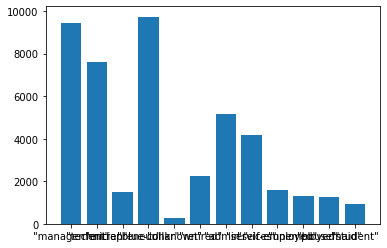

In [27]:
# First find the index of the column corresponding to the "job"
col_idx_job=findCol(firstLine, "job")
print("{} corresponds to column {}".format("job", col_idx_job))

# Count the ages status in RDD
jobs = bankData.map(lambda x: x[col_idx_job]).map(lambda a: (a, 1))
jobs1 = jobs.reduceByKey(lambda a,b: a+b)

# collect
jobs2 = jobs1.collect()
#print(ages2)

# plot histogram
jobs3= dict(jobs2)
plt.bar(jobs3.keys(), jobs3.values())

#### Which job provide the most money
- use job and balance columns in dataset

In [45]:
# Job columns
job = bankData.map(lambda x: x[col_idx_job])
job.take(3)

['"management"', '"technician"', '"entrepreneur"']

In [44]:
# balance columns

# First find the index of the column corresponding to the "balance"
col_idx_bal=findCol(firstLine, "balance")
print("{} corresponds to column {}".format("balance", col_idx_bal))

# Count the ages status in RDD
balance = bankData.map(lambda x: x[col_idx_bal])
balance.take(3)

balance corresponds to column 5


['2143', '29', '2']

In [47]:
# Create RDD with both job and balance

# Method 1
job_balance = bankData.map(lambda x: (x[col_idx_job], x[col_idx_bal]))
job_balance.take(3)

[('"management"', '2143'), ('"technician"', '29'), ('"entrepreneur"', '2')]

In [84]:
# Method 2
#job_balance = job.zip(balance)
#job_balance.take(3)

In [85]:
# remove job =unknown
job_balance = job_balance.filter(lambda x: x[0] != '"unknown"')

In [86]:
# Most lucrative job on average 
job_rich = job_balance.map(lambda x: (x[0], float(x[1]))).groupByKey().mapValues(lambda x: sum(x) / len(x))

In [87]:
# reverse inorder to sort
rev_jobRich = job_rich.map(lambda x: (x[1], x[0]))
sorted_revJobRich = rev_jobRich.sortByKey(ascending=False)

# print the most lucrative job
print('%s is the most prolific job with average yearly balance of %d euros' % (sorted_revJobRich.first()[1], sorted_revJobRich.first()[0]))

"retired" is the most prolific job with average yearly balance of 1984 euros


In [88]:
#take the top 5 most paid job
D = sorted_revJobRich.take(5)
print('Top 5 most paid job on average \n'+'\n'.join(['%d:\t%s'%c for c in D]))

Top 5 most paid job 
1984:	"retired"
1763:	"management"
1647:	"self-employed"
1521:	"unemployed"
1521:	"entrepreneur"


## End

In [89]:
#sc.stop()